Forecasts:
   unique_id                  ds   AutoARIMA
0          1 2025-01-11 00:00:00  296.102191
1          1 2025-01-11 01:00:00  297.108076
2          1 2025-01-11 02:00:00  296.571900
3          1 2025-01-11 03:00:00  298.084297
4          1 2025-01-11 04:00:00  300.359311


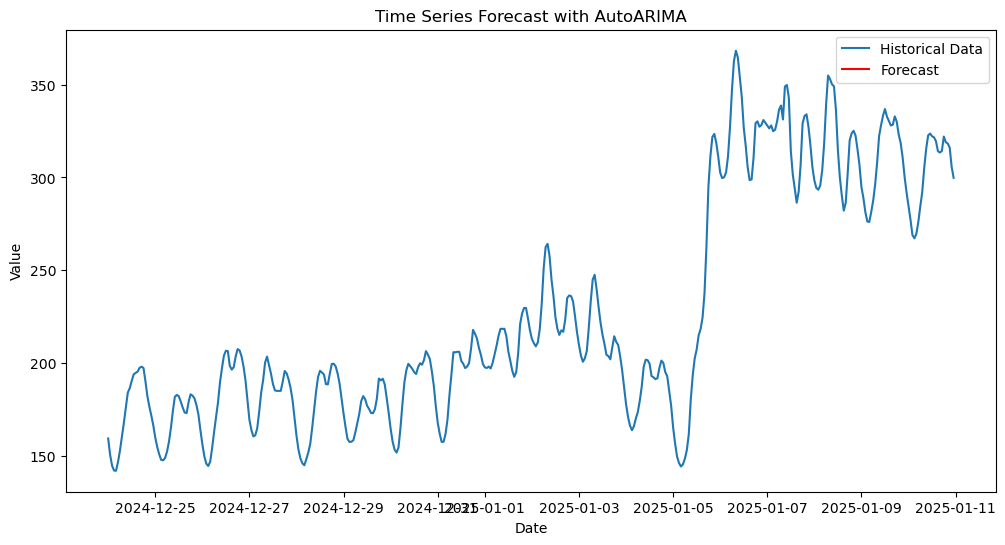

ValueError: operands could not be broadcast together with shapes (14,) (0,) 

In [11]:
import os
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from utilsforecast.losses import mse

import matplotlib.pyplot as plt
# Set the environment variable to adopt the new behavior
os.environ['NIXTLA_ID_AS_COL'] = '1'

df = pd.read_csv("ercot_load_data.csv")
df['ds'] = pd.to_datetime(df['date'])  # Ensure 'date' is in datetime format
df['y'] = pd.to_numeric(df['values'], errors='coerce')  # Convert 'values' to numeric
df = df.sort_values('ds')  # Sort by date
df = df.dropna(subset=['ds', 'y'])  # Drop rows with missing or NaN values

# Resample the data to hourly frequency (limit dataset size if necessary)
df = df.set_index('ds').resample('h')['y'].mean().reset_index() 
df["unique_id"] = 1

# Define hold-out period
hold_out_hours = 24  # 24 hours = 1 day
train = df.iloc[:-hold_out_hours]
hold_out = df.iloc[-hold_out_hours:]


# Initialize the StatsForecast model
models = [AutoARIMA(season_length=7)]
sf = StatsForecast(models=models, freq='h', n_jobs=-1)
# Fit the model and generate forecasts
horizon = 14
forecasts = sf.forecast(df=df, h=horizon)
print("Forecasts:")
print(forecasts.head())
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Historical Data')
# Check if 'unique_id' is in the columns (new behavior)
if 'unique_id' in forecasts.columns:
    forecasts = forecasts[forecasts['unique_id'] == 'series1']
plt.plot(forecasts['ds'], forecasts['AutoARIMA'], label='Forecast', color='red')
plt.title('Time Series Forecast with AutoARIMA')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.savefig("AutoARIMA.png")
plt.show()
# Calculate and print forecast metrics
actual_values = df.iloc[-horizon:]
forecast_values = forecasts['AutoARIMA']
mse_value = mse((actual_values['y'].values - forecast_values.values) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(actual_values['y'].values - forecast_values.values))
print(f"\nForecast Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

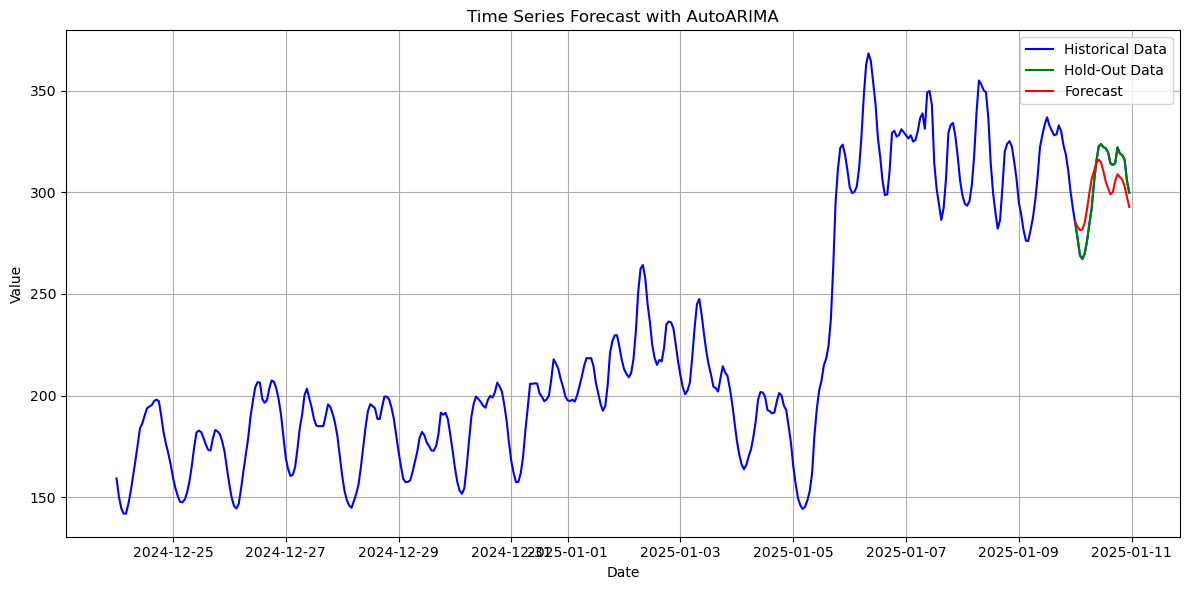


Forecast Metrics:
Mean Squared Error (MSE): 142.56
Root Mean Squared Error (RMSE): 11.94
Mean Absolute Error (MAE): 11.00


In [49]:
import os
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from utilsforecast.losses import mse, mape

import matplotlib.pyplot as plt

# Set environment variable
os.environ['NIXTLA_ID_AS_COL'] = '1'

# Load and preprocess the data
df = pd.read_csv("ercot_load_data.csv")
df['ds'] = pd.to_datetime(df['date'])  # Ensure 'date' is in datetime format
df['y'] = pd.to_numeric(df['values'], errors='coerce')  # Convert 'values' to numeric
df = df.sort_values('ds')  # Sort by date
df = df.dropna(subset=['ds', 'y'])  # Drop rows with missing values

# Resample the data to hourly frequency
df = df.set_index('ds').resample('h')['y'].mean().reset_index()
df["unique_id"] = "series1"  # Assign a unique ID for StatsForecast compatibility

# Split the data into training and hold-out sets
hold_out_hours = 24
train = df.iloc[:-hold_out_hours]
hold_out = df.iloc[-hold_out_hours:]

# Initialize and fit the StatsForecast model
models = [AutoARIMA(season_length=24)]  # Adjust seasonality to daily
sf = StatsForecast(models=models, freq='h', n_jobs=-1)
sf.fit(train)

# Generate forecasts for the hold-out period
horizon = len(hold_out)
forecasts = sf.predict(h=horizon)

# Add timestamps to the forecast results
forecasts['ds'] = hold_out['ds'].values

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(df['ds'], df['y'], label='Historical Data', color='blue')

# Highlight hold-out data in green
plt.plot(hold_out['ds'], hold_out['y'], label='Hold-Out Data', color='green')

# Plot forecasted data in red
plt.plot(forecasts['ds'], forecasts['AutoARIMA'], label='Forecast', color='red')

# Add labels, title, and legend
plt.title('Time Series Forecast with AutoARIMA')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("AutoARIMA_Forecast.png")
plt.show()

# Calculate and print forecast metrics
actual_values = hold_out['y'].values
forecast_values = forecasts['AutoARIMA'].values

mse_value = np.mean((actual_values - forecast_values) ** 2)
rmse_value = np.sqrt(mse_value)
mae_value = np.mean(np.abs(actual_values - forecast_values))

print("\nForecast Metrics:")
print(f"Mean Squared Error (MSE): {mse_value:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_value:.2f}")
print(f"Mean Absolute Error (MAE): {mae_value:.2f}")


In [29]:
from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

# Create a list of models and instantiation parameters
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=24),
    HistoricAverage(),
    DOT(season_length=24)
]
# Instantiate StatsForecast class as sf
sf = StatsForecast( 
    models=models,
    freq='h', 
    fallback_model = SeasonalNaive(season_length=7),
    n_jobs=-1,
)

forecasts_df = sf.forecast(df=train, h=48, level=[90])
forecasts_df.head()


,unique_id,ds,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,HistoricAverage,HistoricAverage-lo-90,HistoricAverage-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
0,series1,2025-01-10 00:00:00,332.900,280.191486,385.608514,332.900,280.191486,385.608514,294.850,228.387343,361.312657,221.715768,121.621188,321.810348,280.285176,273.124586,289.316941
1,series1,2025-01-10 01:00:00,330.050,277.341486,382.758514,330.050,277.341486,382.758514,288.950,222.487343,355.412657,221.715768,121.621188,321.810348,272.122947,261.614279,283.097729
2,series1,2025-01-10 02:00:00,323.075,270.366486,375.783514,323.075,270.366486,375.783514,281.325,214.862343,347.787657,221.715768,121.621188,321.810348,266.541998,251.619256,279.264856
3,series1,2025-01-10 03:00:00,318.575,265.866486,371.283514,318.575,265.866486,371.283514,276.250,209.787343,342.712657,221.715768,121.621188,321.810348,264.626030,249.636264,277.525978
4,series1,2025-01-10 04:00:00,310.825,258.116486,363.533514,310.825,258.116486,363.533514,276.025,209.562343,342.487657,221.715768,121.621188,321.810348,267.711971,252.103898,283.497104


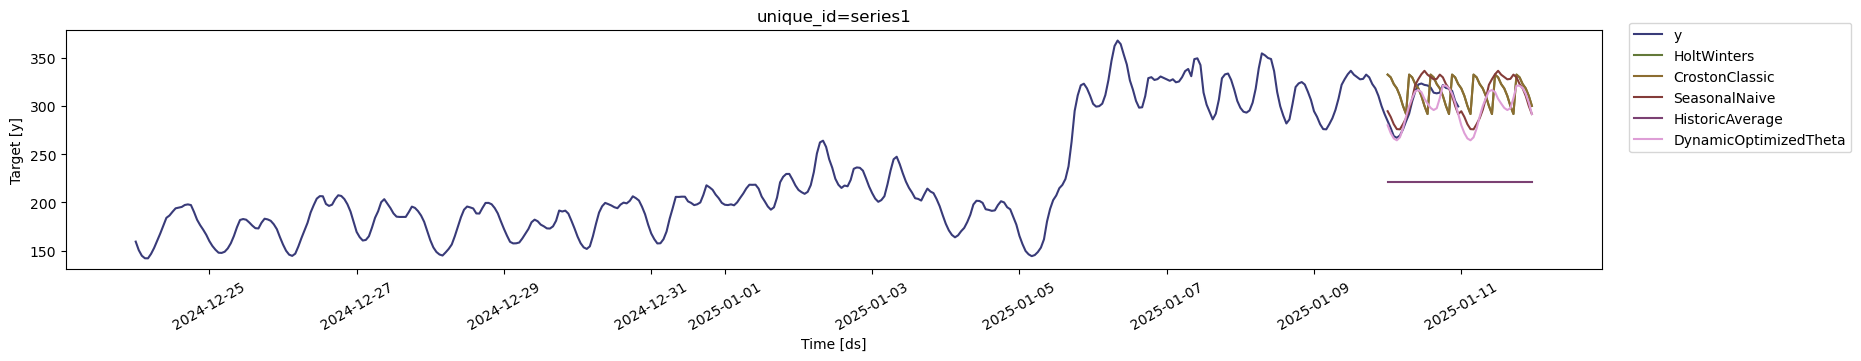

In [33]:
sf.plot(df,forecasts_df)


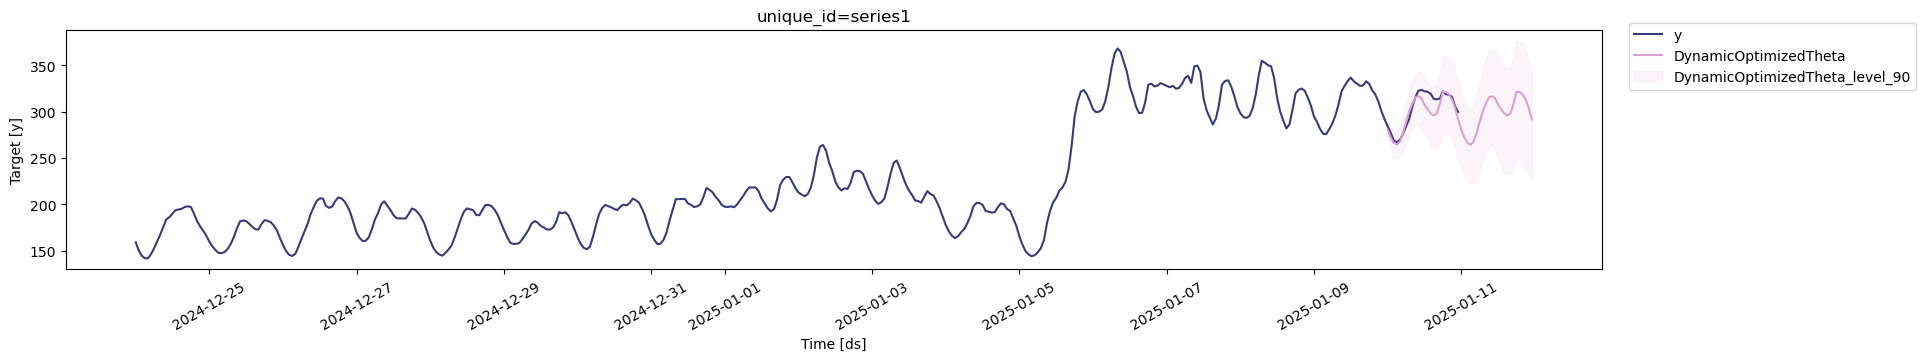

In [53]:
# Plot to unique_ids and some selected models
sf.plot(df, forecasts_df, models=["DynamicOptimizedTheta"],  level=[90])


In [39]:
cv_df = sf.cross_validation(
    df=df,
    h=24,
    step_size=24,
    n_windows=2
)


In [50]:
def evaluate_cv(df, metric):
    models = df.columns.drop(['unique_id', 'ds', 'y', 'cutoff']).tolist()
    evals = metric(df, models=models)
    evals['best_model'] = evals[models].idxmin(axis=1)
    return evals
evaluation_df = evaluate_cv(cv_df, mape)
evaluation_df.head()


,unique_id,HoltWinters,CrostonClassic,SeasonalNaive,HistoricAverage,DynamicOptimizedTheta,best_model
0,series1,0.072913,0.059617,0.053454,0.282231,0.028537,DynamicOptimizedTheta


In [47]:
seasonal_ids = evaluation_df.query('best_model == "SeasonalNaive"')['unique_id']
sf.plot(df,forecasts_df, unique_ids=seasonal_ids, models=["SeasonalNaive","DynamicOptimizedTheta"])


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1600x0 with 0 Axes>

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 447
[LightGBM] [Info] Number of data points in the train set: 404, number of used features: 5
[LightGBM] [Info] Start training from score 222.434922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

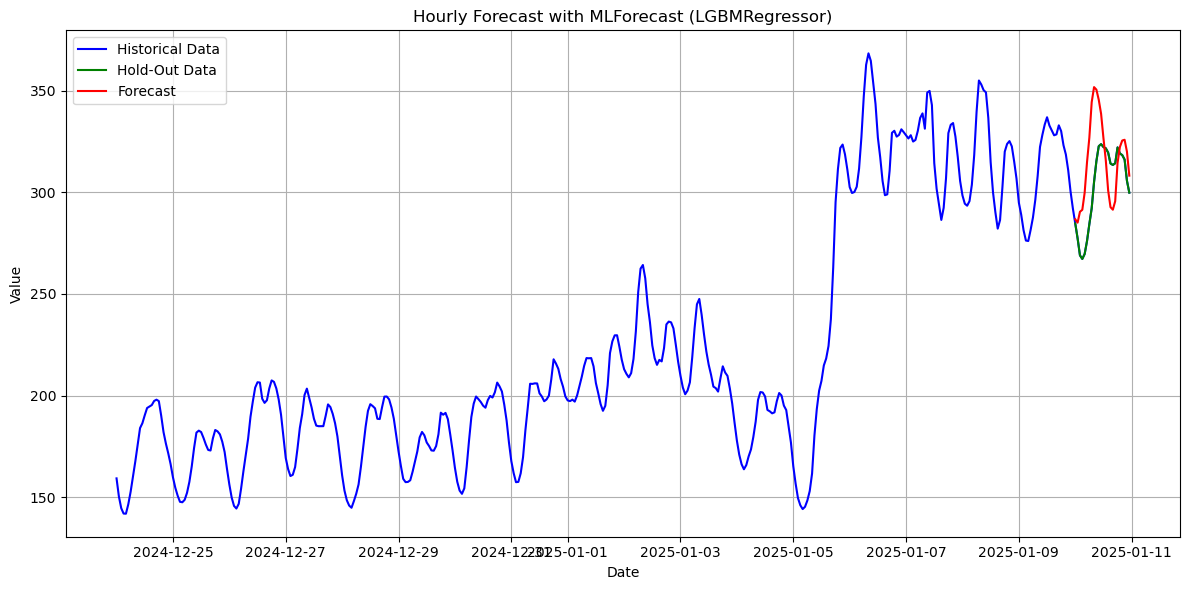


Forecast Metrics:
Mean Squared Error (MSE): 598.98
Root Mean Squared Error (RMSE): 24.47
Mean Absolute Error (MAE): 19.99


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlforecast import MLForecast
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load and preprocess the data
df = pd.read_csv("ercot_load_data.csv")
df['ds'] = pd.to_datetime(df['date'])  # Ensure 'date' is in datetime format
df['y'] = pd.to_numeric(df['values'], errors='coerce')  # Convert 'values' to numeric
df = df.sort_values('ds')  # Sort by date
df = df.dropna(subset=['ds', 'y'])  # Drop rows with missing values

# Resample the data to hourly frequency
df = df.set_index('ds').resample('h')['y'].mean().reset_index()
df['unique_id'] = "series1"  # Required for MLForecast compatibility

# Split the data into training and hold-out sets
hold_out_hours = 24
train = df.iloc[:-hold_out_hours]
hold_out = df.iloc[-hold_out_hours:]

# Initialize the MLForecast model
model = MLForecast(
    models=[LGBMRegressor()],
    freq='h',  # Hourly frequency
    lags=[1, 2, 4],  # Use lags of 1, 2, and 4 hours
    date_features=['hour', 'day']
)

# Fit the model on the training data
model.fit(train)

# Generate forecasts for the hold-out period
horizon = len(hold_out)
forecasts = model.predict(horizon)
forecasts['ds'] = hold_out['ds'].values  # Add timestamps to the forecast results

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(df['ds'], df['y'], label='Historical Data', color='blue')

# Highlight hold-out data in green
plt.plot(hold_out['ds'], hold_out['y'], label='Hold-Out Data', color='green')

# Plot forecasted data in red
plt.plot(forecasts['ds'], forecasts['LGBMRegressor'], label='Forecast', color='red')

# Add labels, title, and legend
plt.title('Hourly Forecast with MLForecast (LGBMRegressor)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("MLForecast_LGBM_Forecast.png")
plt.show()

# Calculate and print forecast metrics
actual_values = hold_out['y'].values
forecast_values = forecasts['LGBMRegressor'].values

mse = mean_squared_error(actual_values, forecast_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, forecast_values)

print("\nForecast Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


In [57]:
!pip install mlforecast

In [59]:
!pip install lightgbm